In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

1. Load the dataset

In [2]:
data = pd.read_csv("loandata.csv")

2. Translate the categorical predictors into numerical predictors

In [3]:
data_numeric=pd.get_dummies(data, drop_first=True)

3. Shuffle and split the data set

In [9]:
# Separate X and y first
y = data["Default"]              
X = data.drop(columns=["Default"])

# Encode predictors only
X_numeric = pd.get_dummies(X, drop_first=True)

# Split 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_numeric, y, test_size=0.4, random_state=42, shuffle=True
)
# Second split: 30% validation, 10% test(0.25*40%=10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

4. Calculate the accuracy of the naive benchmark (majority predictor) on the validation set.

In [11]:
# Majority class in training set
majority_class = y_train.value_counts().idxmax()

# Predict majority class for validation set
y_val_pred_naive = np.full_like(y_val, majority_class)

naive_accuracy = accuracy_score(y_val, y_val_pred_naive)
print("Naive benchmark accuracy:", naive_accuracy)

Naive benchmark accuracy: 0.7458745874587459


5. Decision tree with accuracy & max_depth

In [14]:
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

train_acc = accuracy_score(y_train, tree.predict(X_train))
val_acc = accuracy_score(y_val, tree.predict(X_val))

print("Training accuracy:", train_acc)
print("Validation accuracy:", val_acc)

Training accuracy: 0.8894389438943895
Validation accuracy: 0.8399339933993399


In [34]:
depths = range(1, 21)
train_scores = []
val_scores = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
    val_scores.append(accuracy_score(y_val, clf.predict(X_val)))


val_scores   

[0.8399339933993399,
 0.8448844884488449,
 0.8448844884488449,
 0.834983498349835,
 0.8399339933993399,
 0.8316831683168316,
 0.8432343234323433,
 0.8316831683168316,
 0.8118811881188119,
 0.8151815181518152,
 0.8184818481848185,
 0.8184818481848185,
 0.8151815181518152,
 0.8168316831683168,
 0.8151815181518152,
 0.8184818481848185,
 0.8184818481848185,
 0.8151815181518152,
 0.8201320132013201,
 0.8201320132013201]

In [41]:
threshold = max(val_scores) 
candidate_depths = [d for d, v in zip(depths, val_scores) if v >= threshold]
chosen_depth = max(candidate_depths)
print("Chosen max_depth (near-best & simplest):", chosen_depth)

Chosen max_depth (near-best & simplest): 3


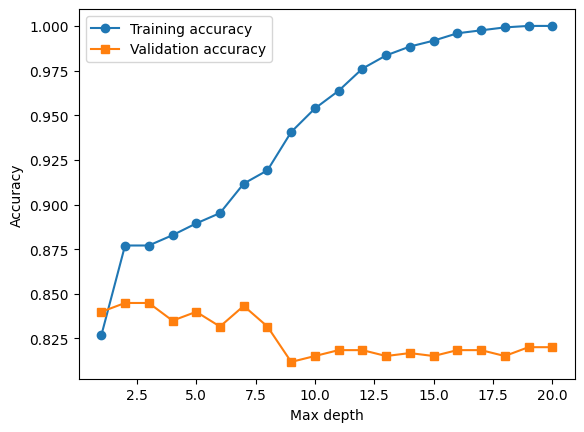

In [42]:
import matplotlib.pyplot as plt

plt.plot(depths, train_scores, 'o-', label="Training accuracy")
plt.plot(depths, val_scores, 's-', label="Validation accuracy")
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


The maximum depth is chosen to balance model complexity and generalisation performance. Deeper trees overfit the training data, while shallow trees underfit. We tune the decision tree’s maximum depth using the validation set. While training accuracy increases monotonically with depth, validation accuracy peaks at shallow depths and then declines, indicating overfitting for deeper trees. We therefore choose a max depth of 3(or 2), which achieves the highest validation accuracy while keeping the model simple and interpretable.

The validation accuracy is the same for depth equal to 2 and 3, which is about 0.8448844884488449. Thus, if we want to create a simple decision tree we can choose depth at 2 which achieve a same accuracy as depth at 3. 

In [26]:
estimators = [10, 25, 50, 100, 200]
rf_train_acc = []
rf_val_acc = []

for n in estimators:
    rf = RandomForestClassifier(
        n_estimators=n,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    rf_train_acc.append(accuracy_score(y_train, rf.predict(X_train)))
    rf_val_acc.append(accuracy_score(y_val, rf.predict(X_val)))

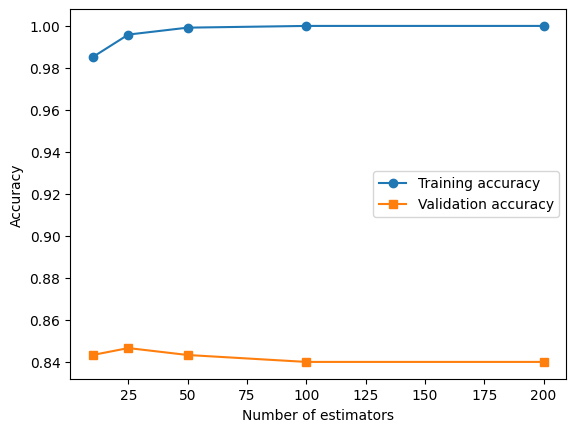

In [43]:
plt.plot(estimators, rf_train_acc, 'o-', label="Training accuracy")
plt.plot(estimators, rf_val_acc, 's-', label="Validation accuracy")
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [63]:
import time

train_times = []

for n in estimators:
    rf = RandomForestClassifier(
        n_estimators=n,
        random_state=42,
        n_jobs=-1
    )
    start = time.time()
    rf.fit(X_train, y_train)
    train_times.append(time.time() - start)


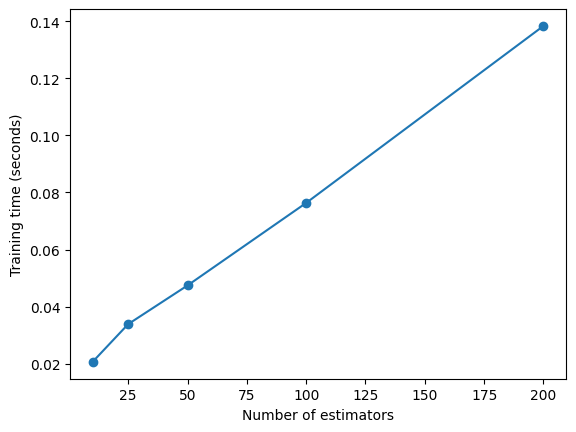

In [64]:
plt.plot(estimators, train_times,'o-')
plt.xlabel("Number of estimators")
plt.ylabel("Training time (seconds)")
plt.show()


The decision tree is easy to interpret and fast to train, but it tends to overfit and shows limited generalisation performance.

The random forest achieves higher validation accuracy and better generalisation by averaging multiple trees, at the cost of increased training time and reduced interpretability.